# Neural network

### Try to use our own preprocessing

In [73]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA
import warnings
from pathlib import Path

from utils.data_processing import create_feables
from utils.data_processing import confusion_matrix

warnings.simplefilter("ignore")

# You should run the ../../data_preprocessing.ipynb notebook to generate the data before running this
data = pd.read_csv("../../datasets/data.csv")
#data = data.tail(1000)


# league_cols = [col for col in data.columns if 'League_' in col]
# print(league_cols)
# data = data.drop(league_cols, axis=1)
# data = data.tail(3000)

#labels = data.loc[:,'label']
#features = data.drop('label', axis = 1)

### Train test split with the test set being the results of the last 3 months. 

In [74]:
data = data.sort_values(['season', 'month'], ascending=(True, True))
test = data[(data['season'] == 2015) & (data['month'] > 8)]

y_test = test.loc[:, 'label']
X_test = test.drop('label', axis=1)

train = data[~data.isin(test)].dropna(how = 'all')
y_train = data.loc[:, 'label']
X_train = data.drop('label', axis=1)

In [75]:
from sklearn.model_selection import train_test_split
#Splitting the data into train, test
#X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 42, shuffle = True, stratify = labels)

# Show some rows of the data
#X_train.head()

In [76]:
# print(y_test)
print("Number of wins in test set:", np.sum(y_test == 2))
print("Number of draws in test set:", np.sum(y_test == 1))
print("Number of defeats in test set:", np.sum(y_test == 0))

Number of wins in test set: 457
Number of draws in test set: 268
Number of defeats in test set: 325


In [77]:
# Match outcome
y_train.head()

# Number of possible outcomes
# 2 = win
# 1 = draw
# 0 = lose
print('Number of possible outcomes', np.unique(y_train.values).shape[0])
labels = np.unique(y_train.values)
print("Labels:", labels)


Number of possible outcomes 3
Labels: [0 1 2]


In [78]:
# Get number of columns by getting the number of columns in the X_train
columns = X_train.shape[1]
print('Number of columns:', columns)

Number of columns: 31


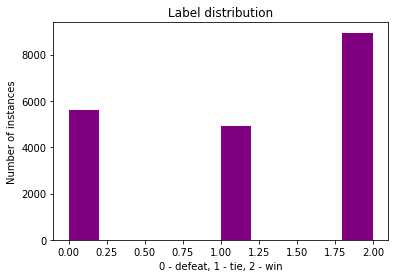

In [79]:
import matplotlib.pyplot as plt

# Plot the distribution of labels in the train data
def plot_labels_histogram(data):
    plt.hist(data, facecolor='purple', align='mid')
    plt.ylabel('Number of instances')
    plt.xlabel('0 - defeat, 1 - tie, 2 - win')
    plt.title("Label distribution")
    
plot_labels_histogram(y_train)

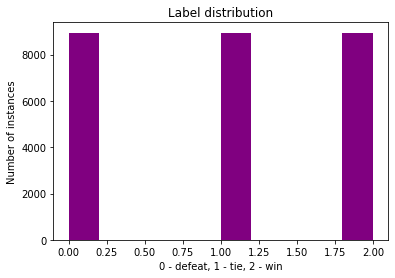

In [80]:
from imblearn.over_sampling import RandomOverSampler

# Since the train data is uneven and the dataset is not "huge" we need to upsamle/oversample
sampler = RandomOverSampler()
X_train_sampled, y_train_sampled = sampler.fit_sample(X_train, y_train)

# Plot the oversampled train set
plot_labels_histogram(y_train_sampled)

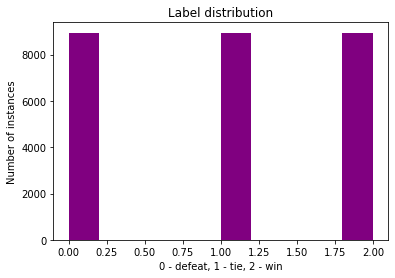

In [81]:
from sklearn.utils import shuffle

# Assign train values with the new sampled data
X_train, y_train = shuffle(X_train_sampled, y_train_sampled, random_state=42)

plot_labels_histogram(y_train)

In [94]:
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Flatten, Dense, Dropout
from keras.optimizers import SGD, Adam
from keras import regularizers

def create_model(learning_rate=1e-5, dropout_rate=0.1):
    model = Sequential() 
    model.add(Dense(128, input_dim=columns, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(8, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    return model

In [95]:
from keras.utils.np_utils import to_categorical

# Convert a class vector (integers) to binary class matrix.
print("Label: \n", y_train.iloc[0])
print("Unique labels in the train set: ", np.unique(y_train))
# One hot encoding
y_train_categorical = to_categorical(y_train, num_classes=len(labels))
print("Unique labels in the train set after encoding: ", np.unique(y_train_categorical, axis=0))
# print("In categorical form: \n", y_train_categorical[0])

print("Number of wins in test set:", np.sum(y_train == 2))
print("Number of draws in test set:", np.sum(y_train == 1))
print("Number of defeats in test set:", np.sum(y_train == 0))

print("------------------------------------------------------------------------------ \n")


Label: 
 0
Unique labels in the train set:  [0 1 2]
Unique labels in the train set after encoding:  [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
Number of wins in test set: 8947
Number of draws in test set: 8947
Number of defeats in test set: 8947
------------------------------------------------------------------------------ 



In [99]:
learning_rates = [1e-3, 5e-3, 1e-4, 5e-4, 1e-5]
dropout_rates = [0.05, 0.1, 0.2]

best_lr = None
best_dr = None

best_val_acc = 0

for lr in learning_rates:
    for dr in dropout_rates:
        print('Learning rate: {0}, Dropout rate: {1}'.format(lr, dr))
        model = create_model(lr, dr)
        history = model.fit(
            X_train,
            y_train_categorical,
            batch_size=128,
            epochs=100,
            validation_split=0.2,
            verbose=0)
        val_acc = max(history.history['val_accuracy'])
        acc = max(history.history['accuracy'])
        print('Accuracy: {0}, Validation accuracy: {1}'.format(acc, val_acc))
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_lr = lr
            best_dr = dr
        
        

Learning rate: 0.001, Dropout rate: 0.05
Accuracy: 0.33518069982528687, Validation accuracy: 0.33935555815696716
Learning rate: 0.001, Dropout rate: 0.1
Accuracy: 0.3359724283218384, Validation accuracy: 0.33935555815696716
Learning rate: 0.001, Dropout rate: 0.2
Accuracy: 0.3350875675678253, Validation accuracy: 0.33395418524742126
Learning rate: 0.005, Dropout rate: 0.05
Accuracy: 0.339884489774704, Validation accuracy: 0.34121811389923096
Learning rate: 0.005, Dropout rate: 0.1
Accuracy: 0.3387202024459839, Validation accuracy: 0.33935555815696716
Learning rate: 0.005, Dropout rate: 0.2
Accuracy: 0.3403502106666565, Validation accuracy: 0.33935555815696716
Learning rate: 0.0001, Dropout rate: 0.05
Accuracy: 0.33825448155403137, Validation accuracy: 0.34792324900627136
Learning rate: 0.0001, Dropout rate: 0.1
Accuracy: 0.33583271503448486, Validation accuracy: 0.34084558486938477
Learning rate: 0.0001, Dropout rate: 0.2
Accuracy: 0.3357861340045929, Validation accuracy: 0.33395418524

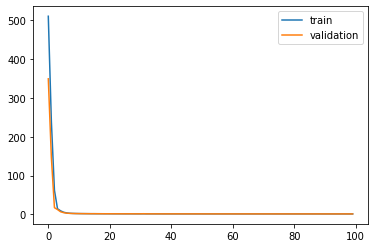

In [84]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

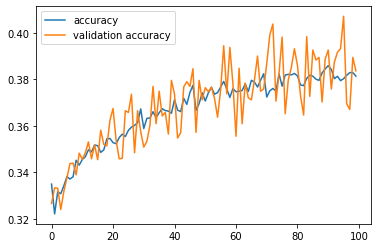

In [85]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [89]:
# Take the most probable prediction
# print(model.predict(X_test))
predictions = np.argmax(model.predict(X_test), axis=1)
print(np.unique(predictions))
# Calculate accuracy
accuracy = (predictions == y_test).mean()
print("Test set accuracy:", accuracy)

[0 1 2]
Test set accuracy: 0.3476190476190476


# Let us plot the confusion matrix

558
[0 1 2]
Neural network confusion matrix: 
                    Home wins (pred)  Draw (pred)  Home loses (pred)
Home wins (true)                 90          301                 66
Draw (true)                      60          147                 61
Home loses (true)                87          110                128

 True labels distribution: 



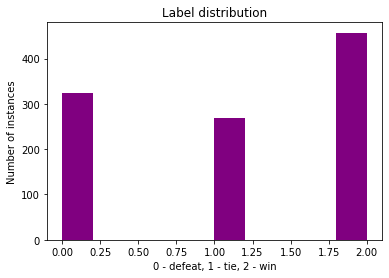

In [87]:
# from utils.data_processing import build_confusion_matrix

# TODO: Remove this and use the commented import instead
def build_confusion_matrix(y_true, y_pred):
    return pd.DataFrame(confusion_matrix(y_true, y_pred, labels=[2, 1, 0]),
                        index=['Home wins (true)', 'Draw (true)', 'Home loses (true)'],
                        columns=['Home wins (pred)', 'Draw (pred)', 'Home loses (pred)'])

print(np.sum((predictions == 1)))
print(np.unique(predictions))
print("Neural network confusion matrix: \n", build_confusion_matrix(y_test, predictions))


print('\n True labels distribution: \n')
plot_labels_histogram(y_test)

# Comparing Neural network to Random forest

In [88]:
#Splitting the data into Train, Calibrate, and Test data sets
X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0, stratify = labels)
X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate, test_size = 0.25, random_state = 0, stratify = y_train_calibrate)


ValueError: Found input variables with inconsistent numbers of samples: [1000, 3]

In [ ]:
from utils.data_processing import train_calibrate_predict

# Creating cross validation data splits
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)
cv_sets.get_n_splits(X_train, y_train)

# Init Random Forest
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')

#Specficying scorer and parameters for grid search
feature_len = features.shape[1]
scorer = make_scorer(accuracy_score)
parameters_RF = {'clf__max_features': ['auto', 'log2'], 'dm_reduce__n_components': np.arange(5, feature_len, int(np.around(feature_len/5)))}

#Initializing dimensionality reductions
pca = PCA()
RF_clf.fit(X_train, y_train)

print("Random forest accuracy for train set.".format(RF_clf.__class__.__name__, accuracy_score(y_train, RF_clf.predict(X_train))))
print("Random forest accuracy for test set".format(RF_clf.__class__.__name__, accuracy_score(y_test, RF_clf.predict(X_test))))

#Grid search, calibrate, and test the classifier
calibrated_RF_clf, dm_reduce, train_score, test_score = train_calibrate_predict(clf = RF_clf, dm_reduction = pca, X_train = X_train, y_train = y_train,
                                                                  X_calibrate = X_calibrate, y_calibrate = y_calibrate,
                                                                  X_test = X_test, y_test = y_test, cv_sets = cv_sets,
                                                                  params = parameters_RF, scorer = scorer, jobs = 1, use_grid_search = True)

In [ ]:
rf_predictions = RF_clf.predict(X_test)

# Calculate accuracy
accuracy = (rf_predictions == y_test).mean()
print("Random forest test set accuracy:", accuracy)

In [ ]:
print("Random forest confusion matrix: \n", build_confusion_matrix(y_test, rf_predictions))

# Conclusion